In [ ]:
!nvcc --version 
!pip install -U mxnet-cu101==1.9.0    
!pip install --upgrade gluoncv
!pip install open3d

import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet.gluon.data.vision import transforms
import gluoncv

ctx = mx.gpu(0)
%matplotlib inline

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
# url = 'https://raw.githubusercontent.com/KuangHaofei/GluonCV_Test/master/monodepthv2/tutorials/test_img.png'
# filename = 'test_img.png'
# gluoncv.utils.download(url, filename, True)

729KB [00:00, 10605.45KB/s]            


'test_img.png'

Then we load the image and visualize it,



box.jpg  car1.jpg  car2.jpg  chair.jpg	sample_data  test_output.png


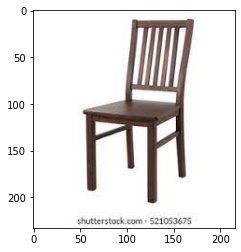

In [ ]:
!ls
import PIL.Image as pil
img = pil.open('chair.jpg').convert('RGB')

plt.imshow(img)
plt.show()

We resize the image make it has the same input size with pretrained model,
and transfer the image to NDArray,



In [ ]:
original_width, original_height = img.size
print(img.size)
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

(216, 233)


## Load the pre-trained model and make prediction

Next, we get a pre-trained model from our model zoo,



In [ ]:

model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_mono_stereo_640x192',
                                    pretrained_base=False, ctx=ctx, pretrained=True)

We directly make disparity map predictions on the image, and resize it to input size



In [ ]:
outputs = model.predict(img)

In the end, we add normalized color map for visualizing the predicted disparity map,



In [ ]:
outputs[('disp', 0)].shape
# disp_resized.shape

(1, 1, 192, 640)

<class 'PIL.Image.Image'>


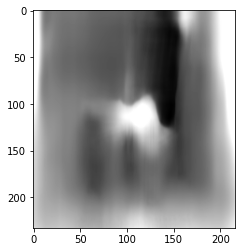

In [ ]:


disp_resized = mx.nd.contrib.BilinearResize2D(outputs[("disp", 0)], height=original_height, width=original_width)
import matplotlib as mpl
import matplotlib.cm as cm
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
vmax = np.percentile(disp_resized_np, 95)
normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='gray')
colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
im = pil.fromarray(colormapped_im)
print(type(im))
im.save('test_output.png')

import matplotlib.image as mpimg
disp_map = mpimg.imread('test_output.png')
plt.imshow(disp_map)
plt.show()

In [ ]:

import imageio
arr = disp_resized[0][0].asnumpy().astype(np.float32)

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
cap = cv.VideoCapture('drive/MyDrive/yhacks/dataset/armflapping_0/afn1.mp4')
c=0
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('output.avi', fourcc, 30.0, (224,  224))
while cap.isOpened():
    ret, frame = cap.read()
    c+=1
    print(c)
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    img = cv.resize(frame, (224, 224))
    img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)
    outputs = model.predict(img)
    # outputs[('disp', 0)].shape
    disp_resized = mx.nd.contrib.BilinearResize2D(outputs[("disp", 1)], height=224, width=224)
    import matplotlib as mpl
    import matplotlib.cm as cm
    disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
    vmax = np.percentile(disp_resized_np, 95)
    normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
    im = pil.fromarray(colormapped_im)
    open_cv_image = np.array(im) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    out.write(open_cv_image)
    # cv2_imshow(open_cv_image)

    # if frame is read correctly ret is True
    # gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # cv.imshow('frame', gray)
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
out.release()
cv.destroyAllWindows()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
Can't receive frame (stream end?). Exiting ...


In [ ]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture(cv.samples.findFile('drive/MyDrive/yhacks/dataset/armflapping_0/afn1.mp4'))
ret, frame1 = cap.read()
frame1 = cv.resize(frame1, (224, 224))
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('output2.avi', fourcc, 30.0, (224,  224))
while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame2 = cv.resize(frame2, (224, 224))
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    # cv.imshow('frame2', bgr)
    out.write(bgr)
    k = cv.waitKey(30) & 0xff
    if cv.waitKey(1) == ord('q'):
        break
    prvs = next
cap.release()
out.release()
cv.destroyAllWindows()

No frames grabbed!


In [ ]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.5 MB/s 


In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose

# Setup the Pose function for images - independently for the images standalone processing.
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Setup the Pose function for videos - for video processing.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)

# Initialize mediapipe drawing class - to draw the landmarks points.
mp_drawing = mp.solutions.drawing_utils
def detectPose(image_pose, pose, draw=False, display=False):
    
    original_image = image_pose.copy()
    
    image_in_RGB = cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB)
    
    resultant = pose.process(image_in_RGB)

    if resultant.pose_landmarks and draw:    

        mp_drawing.draw_landmarks(image=original_image, landmark_list=resultant.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=3, circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                                               thickness=2, circle_radius=2))

    if display:
            
            plt.figure(figsize=[22,22])
            plt.subplot(121);plt.imshow(image_pose[:,:,::-1]);plt.title("Input Image");plt.axis('off');
            plt.subplot(122);plt.imshow(original_image[:,:,::-1]);plt.title("Pose detected Image");plt.axis('off');

    else:
        
        return original_image, results



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np


def pixel_coord_np(width, height):
    """
    Pixel in homogenous coordinate
    Returns:
        Pixel coordinate:       [3, width * height]
    """
    x = np.linspace(0, width - 1, width).astype(np.int)
    y = np.linspace(0, height - 1, height).astype(np.int)
    [x, y] = np.meshgrid(x, y)
    return np.vstack((x.flatten(), y.flatten(), np.ones_like(x.flatten())))


def intrinsic_from_fov(height, width, fov=90):
    """
    Basic Pinhole Camera Model
    intrinsic params from fov and sensor width and height in pixels
    Returns:
        K:      [4, 4]
    """
    px, py = (width / 2, height / 2)
    hfov = fov / 360. * 2. * np.pi
    fx = width / (2. * np.tan(hfov / 2.))

    vfov = 2. * np.arctan(np.tan(hfov / 2) * height / width)
    fy = height / (2. * np.tan(vfov / 2.))

    return np.array([[fx, 0, px, 0.],
                     [0, fy, py, 0.],
                     [0, 0, 1., 0.],
                     [0., 0., 0., 1.]])

In [ ]:

o3d.visualization.draw_geometries([pcd_cam])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


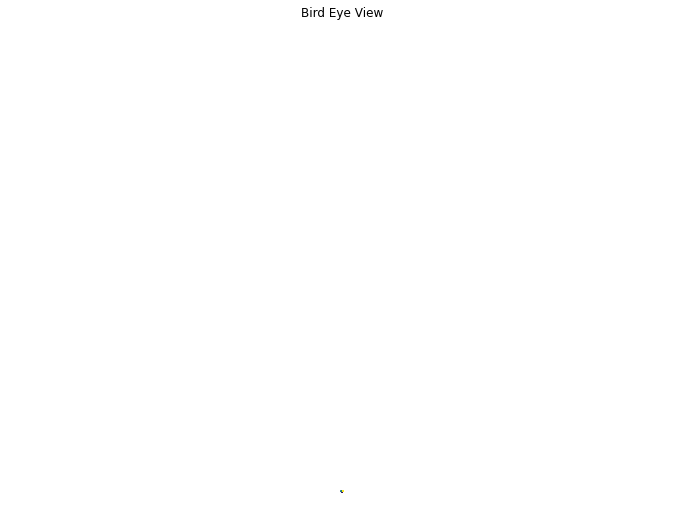

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d


# Load images
rgb = cv2.cvtColor(cv2.imread('test_img.png'), cv2.COLOR_BGR2RGB)

# Depth is stored as float32 in meters
depth = arr #cv2.imread('final_output.exr', cv2.IMREAD_ANYDEPTH)

# Get intrinsic parameters
height, width, _ = rgb.shape
K = intrinsic_from_fov(height, width, 90)  # +- 45 degrees
K_inv = np.linalg.inv(K)

# Get pixel coordinates
pixel_coords = pixel_coord_np(width, height)  # [3, npoints]

# Apply back-projection: K_inv @ pixels * depth
cam_coords = K_inv[:3, :3] @ pixel_coords * depth.flatten()

# back-projection using native for-loop.
# Uncomment block to test this
# cam_coords = np.zeros((height * width, 3))
# u0 = K[0, 2]
# v0 = K[1, 2]
# fx = K[0, 0]
# fy = K[1, 1]
# i = 0
# # Loop through each pixel in the image
# for v in range(height):
#     for u in range(width):
#         # Apply equation in fig 3
#         x = (u - u0) * depth[v, u] / fx
#         y = (v - v0) * depth[v, u] / fy
#         z = depth[v, u]
#         cam_coords[i] = (x, y, z)
#         i += 1
# cam_coords = cam_coords.T


# Limit points to 150m in the z-direction for visualisation
cam_coords = cam_coords[:, np.where(cam_coords[2] <= 150)[0]]

# Visualize
pcd_cam = o3d.geometry.PointCloud()
pcd_cam.points = o3d.utility.Vector3dVector(cam_coords.T[:, :3])
# Flip it, otherwise the pointcloud will be upside down
pcd_cam.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd_cam])


def project_topview(cam_points):
    """
    Draw the topview projection
    """
    max_longitudinal = 70
    window_x = (-50, 50)
    window_y = (-3, max_longitudinal)

    x, y, z = cam_points
    # flip the y-axis to positive upwards
    y = - y

    # We sample points for points less than 70m ahead and above ground
    # Camera is mounted 1m above on an ego vehicle
    ind = np.where((z < max_longitudinal) & (y > -1.2))
    bird_eye = cam_points[:3, ind]

    # Color by radial distance
    dists = np.sqrt(np.sum(bird_eye[0:2:2, :] ** 2, axis=0))
    axes_limit = 10
    colors = np.minimum(1, dists / axes_limit / np.sqrt(2))

    # Draw Points
    fig, axes = plt.subplots(figsize=(12, 12))
    axes.scatter(bird_eye[0, :], bird_eye[2, :], c=colors, s=0.1)
    axes.set_xlim(window_x)
    axes.set_ylim(window_y)
    axes.set_title('Bird Eye View')
    plt.axis('off')

    plt.gca().set_aspect('equal')
    plt.show()


# Do top view projection
project_topview(cam_coords)